In [1]:
import csv
import numpy as np
import pandas as pd
from math import factorial

import datetime
from datetime import date
import datetime
import time

import scipy
import os, os.path
from os import listdir
from os.path import isfile, join

import re
# from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb

import sys


# search path for modules
# look @ https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
import NASA_plot_core as npc

### Set up directories

In [2]:
data_dir = "//Users/hn/Documents/01_research_data/NASA/VI_TS/01_first_investigation_Aug_2021/"

In [3]:
# import glob
# All files ending with .txt
# glob.glob(data_dir + "*.csv")

file_names = [x for x in os.listdir(data_dir) if x.endswith(".csv")]
file_names

['Grant_4Fields_Landsat7_T1_L2_2008-01-01_2021-07-01.csv',
 'Grant_4Fields_Sentinel_70cloud_2015-06-01_2021-07-01.csv',
 'Grant_4Fields_Landsat7_T1_SR_2008-01-01_2021-07-01.csv',
 'Grant_4Fields_Landsat8_T1_SR_2013-01-01_2021-07-01.csv']

In [4]:
dataframe_list = []
for curr_f in file_names:
    A = pd.read_csv(data_dir + curr_f)
    if "Sentinel" in curr_f:
        A["dataset"] = curr_f.split("_")[2]
    elif "noSnowFilter" in curr_f:
        A["dataset"] = curr_f.split("_")[2] + "_" + curr_f.split("_")[3] + "_" + \
                       curr_f.split("_")[4] + "_" + curr_f.split("_")[5]        
    else:
        A["dataset"] = curr_f.split("_")[2] + "_" + curr_f.split("_")[3] + "_" + curr_f.split("_")[4]
        
    A = A[A['NDVI'].notna()]
#     # clean up NA in each field
#     subset_list = []
#     for curr_ID in A.ID.unique():
        
#         A_field = A.loc[A.ID == curr_ID,].copy()
#         A_field = A_field[A_field['NDVI'].notna()]
#         subset_list.append(A_field)
#     A = pd.concat(subset_list)
    dataframe_list.append(A)

all_data = pd.concat(dataframe_list)
all_data.reset_index(drop=True, inplace=True)
unique_fields = list(np.sort(all_data.ID.unique()))

all_data = nc.add_human_start_time_by_system_start_time(all_data)

In [5]:
all_data.head(2)

,ID,county,CropTyp,Irrigtn,LstSrvD,doy,EVI,NDVI,system_start_time,image_year,dataset,human_system_start_time
0,104563_WSDA_SF_2017,Grant,potato,rill,2017/05/16,20.0,0.451096,-0.038306,1.200940e+09,2008.0,Landsat7_T1_L2,2008-01-21
1,105429_WSDA_SF_2017,Grant,"bean, dry",center pivot,2017/05/14,20.0,0.417028,-0.034990,1.200940e+09,2008.0,Landsat7_T1_L2,2008-01-21


### Set the plotting style

In [6]:
size = 15
title_FontSize = 10
legend_FontSize = 8
tick_FontSize = 12
label_FontSize = 14

params = {'legend.fontsize': 'medium',
          'figure.figsize': (6, 4),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size * 0.75,
          'ytick.labelsize': size * 0.75,
          'axes.titlepad': 10}

#
#  Once set, you cannot change them, unless restart the notebook
#
plt.rc('font', family = 'Palatino')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update(params)
# pylab.rcParams.update(params)
# plt.rc('text', usetex=True)

### Set the colors

In [7]:
list(np.sort(list(all_data.dataset.unique())))

['Landsat7_T1_L2', 'Landsat7_T1_SR', 'Landsat8_T1_SR', 'Sentinel']

In [8]:
# These are the colors that will be used in the plot
color_dict = {'Landsat7_8day_NDVIComposite': '#1f77b4',
              'Landsat7_T1_L2': '#8c564b', 
              'Landsat7_T1_L2_noSnowFilter': '#ff7f0e',
              'Landsat7_T1_SR': 'k', # #8c564b
              'Landsat7_T2_SR': '#9467bd',
              'Landsat8_T1_SR': '#2ca02c',
              'Landsat8_T2_SR': '#e377c2',
              'Sentinel': '#d62728'
             }

# """
# ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
# '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
# '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
# '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
# """

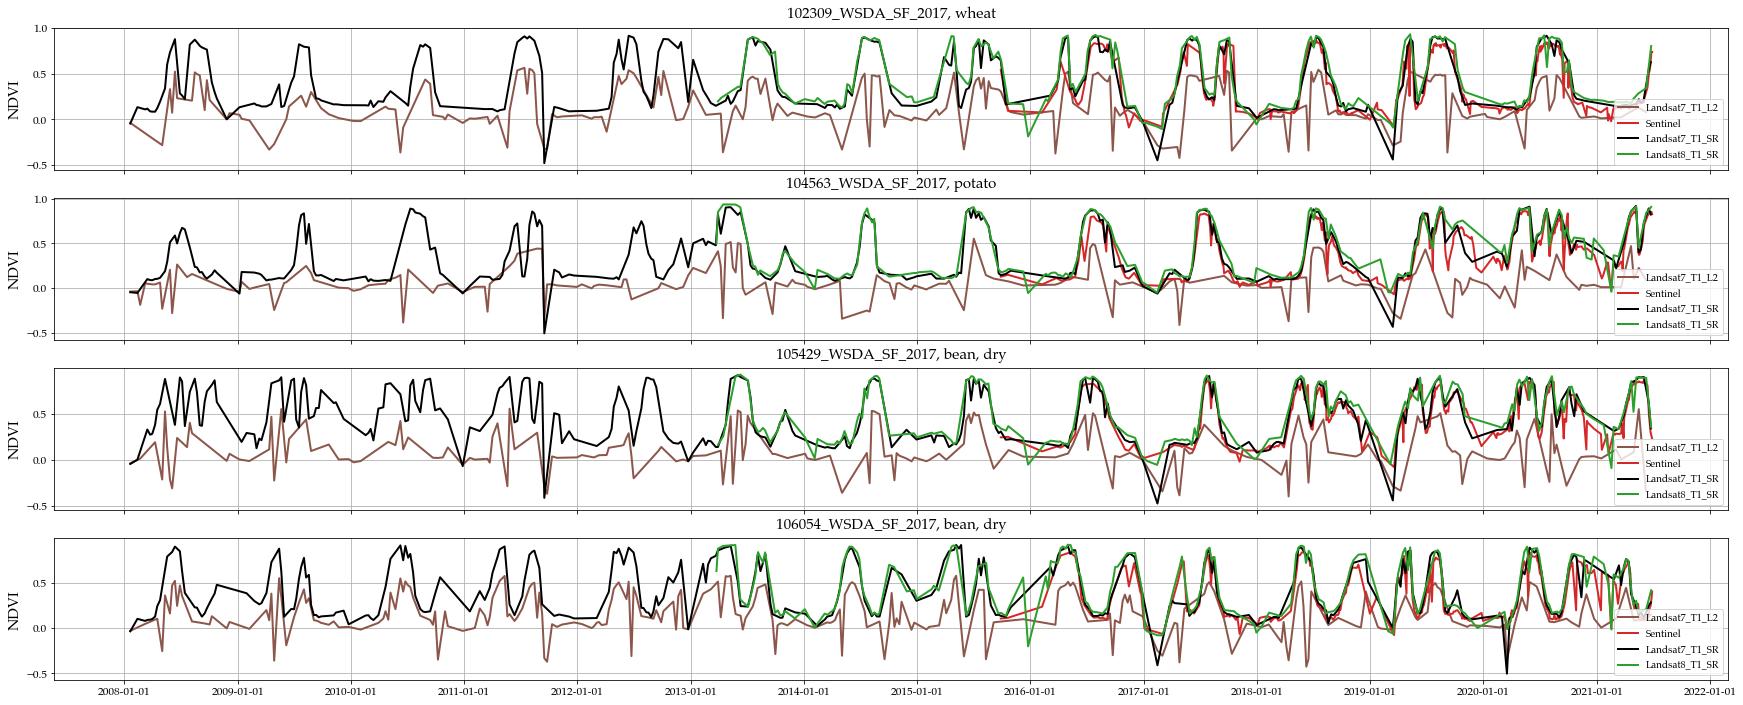

In [9]:
fig, axs = plt.subplots(4, 1, figsize=(30, 12),
                        sharex='col', sharey='row',
                        # sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.2, 'wspace': .05});

(ax1, ax2, ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True)
ax3.grid(True); ax4.grid(True)

dot_s = 80
#######
#######  subplot 1
#######
field_dt = all_data.loc[all_data.ID == unique_fields[0], ].copy()
for curr_dataset in field_dt.dataset.unique():
    curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
    curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
    ax1.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
             '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset]) #  ,
    if "T2" in curr_dataset:
        ax1.scatter(curr_dt['human_system_start_time'], 
                    curr_dt['NDVI'], 
                    color=color_dict[curr_dataset], 
                    s=dot_s)


ax1.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
ax1.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
ax1.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
ax1.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
ax1.legend(loc="lower right");

#######
#######  subplot 2
#######
field_dt = all_data.loc[all_data.ID == unique_fields[1], ].copy()
for curr_dataset in field_dt.dataset.unique():
    curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
    curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
    ax2.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
             '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset]) #  ,
    if "T2" in curr_dataset:
        ax2.scatter(curr_dt['human_system_start_time'], 
                    curr_dt['NDVI'], 
                    color=color_dict[curr_dataset], 
                    s=dot_s)
        

ax2.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
ax2.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
ax2.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
ax2.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
ax2.legend(loc="lower right");

#######
#######  subplot 3
#######
field_dt = all_data.loc[all_data.ID == unique_fields[2], ].copy()
for curr_dataset in field_dt.dataset.unique():
    curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
    curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
    ax3.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
             '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset])
    if "T2" in curr_dataset:
        ax3.scatter(curr_dt['human_system_start_time'], 
                    curr_dt['NDVI'], 
                    color=color_dict[curr_dataset], 
                    s=dot_s)


ax3.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
ax3.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
ax3.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
ax3.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
ax3.legend(loc="lower right");

#######
#######  subplot 4
#######
field_dt = all_data.loc[all_data.ID == unique_fields[3], ].copy()
for curr_dataset in field_dt.dataset.unique():
    curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
    curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
    ax4.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
             '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset])
    if "T2" in curr_dataset:
        ax4.scatter(curr_dt['human_system_start_time'], 
                    curr_dt['NDVI'], 
                    color=color_dict[curr_dataset], 
                    s=dot_s)


ax4.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
ax4.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
ax4.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
ax4.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
ax4.legend(loc="lower right");
ax4.xaxis.set_major_locator(mdates.YearLocator(1))


# plt.xlim([0, 10000])

file_name = data_dir + "Grant_4fields.pdf"
plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)

# We can Stop here. We decided we do not want Tier-2 and 8-Day composite. 

# Exclude Tier 2

In [10]:
# all_data_noTier2 = all_data.loc[(all_data.dataset != "Landsat8_T2_SR") & 
#                                 (all_data.dataset != "Landsat7_T2_SR")]

In [11]:
# fig, axs = plt.subplots(4, 1, figsize=(30, 12),
#                         sharex='col', sharey='row',
#                         gridspec_kw={'hspace': 0.2, 'wspace': .05});

# (ax1, ax2, ax3, ax4) = axs;
# ax1.grid(True); ax2.grid(True)
# ax3.grid(True); ax4.grid(True)


# #######
# #######  subplot 1
# #######
# field_dt = all_data_noTier2.loc[all_data_noTier2.ID == unique_fields[0], ].copy()
# for curr_dataset in field_dt.dataset.unique():
#     curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
#     curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
#     ax1.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
#              '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset])


# ax1.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
# ax1.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
# ax1.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
# ax1.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
# ax1.legend(loc="lower left");


# #######
# #######  subplot 2
# #######
# field_dt = all_data_noTier2.loc[all_data_noTier2.ID == unique_fields[1], ].copy()
# for curr_dataset in field_dt.dataset.unique():
#     curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
#     curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
#     ax2.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
#              '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset])

# ax2.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
# ax2.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
# ax2.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
# ax2.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
# ax2.legend(loc="lower left");

# #######
# #######  subplot 3
# #######
# field_dt = all_data_noTier2.loc[all_data_noTier2.ID == unique_fields[2], ].copy()
# for curr_dataset in field_dt.dataset.unique():
#     curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
#     curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
#     ax3.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
#              '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset])


# ax3.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
# ax3.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
# ax3.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
# ax3.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
# ax3.legend(loc="lower left");

# #######
# #######  subplot 4
# #######
# field_dt = all_data_noTier2.loc[all_data_noTier2.ID == unique_fields[3], ].copy()
# for curr_dataset in field_dt.dataset.unique():
#     curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
#     curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
#     ax4.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
#              '-', label = curr_dataset, linewidth=2, color=color_dict[curr_dataset])

# ax4.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
# ax4.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
# ax4.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
# ax4.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
# ax4.legend(loc="lower left");
# ax4.xaxis.set_major_locator(mdates.YearLocator(1))


# # plt.xlim([0, 10000])

# file_name = data_dir + "Grant_4fields_noTier2.pdf"
# plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)

# Exclude Tier 2 and noSnowFilter

In [12]:
# all_data_noTier2_noSnowFilte = all_data.loc[(all_data.dataset != "Landsat8_T2_SR") & 
#                                             (all_data.dataset != "Landsat7_T2_SR") &
#                                             (all_data.dataset != "Landsat7_T1_L2_noSnowFilter")]

In [13]:
# fig, axs = plt.subplots(4, 1, figsize=(30, 12),
#                         sharex='col', sharey='row',
#                         gridspec_kw={'hspace': 0.2, 'wspace': .05});

# (ax1, ax2, ax3, ax4) = axs;
# ax1.grid(True); ax2.grid(True)
# ax3.grid(True); ax4.grid(True)


# #######
# #######  subplot 1
# #######
# field_dt = all_data_noTier2_noSnowFilte.loc[all_data_noTier2.ID == unique_fields[0], ].copy()
# for curr_dataset in field_dt.dataset.unique():
#     curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
#     curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
#     ax1.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
#              '-', label=curr_dataset, linewidth=2, color=color_dict[curr_dataset])

# ax1.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
# ax1.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
# ax1.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
# ax1.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
# ax1.legend(loc="lower left");


# #######
# #######  subplot 2
# #######
# field_dt = all_data_noTier2_noSnowFilte.loc[all_data_noTier2.ID == unique_fields[1], ].copy()
# for curr_dataset in field_dt.dataset.unique():
#     curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
#     curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
#     ax2.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
#              '-', label=curr_dataset, linewidth=2, color=color_dict[curr_dataset]) #  ,

# ax2.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
# ax2.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
# ax2.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
# ax2.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
# ax2.legend(loc="lower left");

# #######
# #######  subplot 3
# #######
# field_dt = all_data_noTier2_noSnowFilte.loc[all_data_noTier2.ID == unique_fields[2], ].copy()
# for curr_dataset in field_dt.dataset.unique():
#     curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
#     curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
#     ax3.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
#              '-', label=curr_dataset, linewidth=2, color=color_dict[curr_dataset]) #  ,

# ax3.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
# ax3.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
# ax3.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
# ax3.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
# ax3.legend(loc="lower left");

# #######
# #######  subplot 4
# #######
# field_dt = all_data_noTier2_noSnowFilte.loc[all_data_noTier2.ID == unique_fields[3], ].copy()
# for curr_dataset in field_dt.dataset.unique():
#     curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
#     curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
#     ax4.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
#              '-', label=curr_dataset, linewidth=2, color=color_dict[curr_dataset]) #  ,

# ax4.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
# ax4.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
# ax4.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
# ax4.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
# ax4.legend(loc="lower left");
# ax4.xaxis.set_major_locator(mdates.YearLocator(1))


# # plt.xlim([0, 10000])

# file_name = data_dir + "Grant_4fields_noTier2_noNoSnowFilter.pdf"
# plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)

# Exclude Tier 2 and noSnowFilter and Level 2

In [14]:
# all_data_noTier2_noSnowFilte_noL2 = all_data.loc[(all_data.dataset != "Landsat8_T2_SR") & 
#                                                  (all_data.dataset != "Landsat7_T2_SR") &
#                                                  (all_data.dataset != "Landsat7_T1_L2_noSnowFilter") &
#                                                  (all_data.dataset != "Landsat7_T1_L2")]

In [15]:
# fig, axs = plt.subplots(4, 1, figsize=(30, 12),
#                         sharex='col', sharey='row',
#                         gridspec_kw={'hspace': 0.2, 'wspace': .05});

# (ax1, ax2, ax3, ax4) = axs;
# ax1.grid(True); ax2.grid(True)
# ax3.grid(True); ax4.grid(True)


# #######
# #######  subplot 1
# #######
# field_dt = all_data_noTier2_noSnowFilte_noL2.loc[all_data_noTier2.ID == unique_fields[0], ].copy()
# for curr_dataset in field_dt.dataset.unique():
#     curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
#     curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
#     ax1.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
#              '-', label=curr_dataset, linewidth=2, color=color_dict[curr_dataset]) #  ,
#     if "Sentinel" in curr_dataset:
#         ax1.scatter(curr_dt['human_system_start_time'], 
#                 curr_dt['NDVI'], 
#                 color=color_dict[curr_dataset], 
#                 s=40)

# ax1.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
# ax1.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
# ax1.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
# ax1.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
# ax1.legend(loc="lower left");


# #######
# #######  subplot 2
# #######
# field_dt = all_data_noTier2_noSnowFilte_noL2.loc[all_data_noTier2.ID == unique_fields[1], ].copy()
# for curr_dataset in field_dt.dataset.unique():
#     curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
#     curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
#     ax2.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
#              '-', label=curr_dataset, linewidth=2, color=color_dict[curr_dataset]) #  ,
#     if "Sentinel" in curr_dataset:
#         ax2.scatter(curr_dt['human_system_start_time'], 
#                 curr_dt['NDVI'], 
#                 color=color_dict[curr_dataset], 
#                 s=40)

# ax2.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
# ax2.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
# ax2.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
# ax2.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
# ax2.legend(loc="lower left");

# #######
# #######  subplot 3
# #######
# field_dt = all_data_noTier2_noSnowFilte_noL2.loc[all_data_noTier2.ID == unique_fields[2], ].copy()
# for curr_dataset in field_dt.dataset.unique():
#     curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
#     curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
#     ax3.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
#              '-', label=curr_dataset, linewidth=2, color=color_dict[curr_dataset]) #  ,
#     if "Sentinel" in curr_dataset:
#         ax3.scatter(curr_dt['human_system_start_time'], 
#                 curr_dt['NDVI'], 
#                 color=color_dict[curr_dataset], 
#                 s=40)

# ax3.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
# ax3.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
# ax3.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
# ax3.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
# ax3.legend(loc="lower left");

# #######
# #######  subplot 4
# #######
# field_dt = all_data_noTier2_noSnowFilte_noL2.loc[all_data_noTier2.ID == unique_fields[3], ].copy()
# for curr_dataset in field_dt.dataset.unique():
#     curr_dt = field_dt.loc[field_dt.dataset == curr_dataset, ].copy()
#     curr_dt.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
#     ax4.plot(curr_dt['human_system_start_time'], curr_dt['NDVI'], 
#              '-', label=curr_dataset, linewidth=2, color=color_dict[curr_dataset]) #  ,
#     if "Sentinel" in curr_dataset:
#         ax4.scatter(curr_dt['human_system_start_time'], 
#                 curr_dt['NDVI'], 
#                 color=color_dict[curr_dataset], 
#                 s=40)

# ax4.set_title(field_dt.ID.unique()[0] + ", " + field_dt.CropTyp.unique()[0])
# ax4.set_ylabel('NDVI') # , labelpad=20); # fontsize = label_FontSize,
# ax4.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
# ax4.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
# ax4.legend(loc="lower left");
# ax4.xaxis.set_major_locator(mdates.YearLocator(1))


# # plt.xlim([0, 10000])

# file_name = data_dir + "Grant_4fields_noTier2_noL2.pdf"
# plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)